<img src="files/LoraNode7.jpg" width="400" align="left"/>

In [11]:
# print "Reading data from ThingsSpeak with Json (last 7 days)"

import urllib, json
url = 'https://thingspeak.com/channels/666968/feed.json?days=7'
response = urllib.urlopen(url)
data = json.loads(response.read())

import pandas as pd
df = pd.DataFrame.from_dict(data['feeds'])
df.tail(5)

#just use the last 10 measurements
#df=df.tail(300)

df.tail(5)

,created_at,entry_id,field1,field2,field3,field4,field5,field6,field7,field8
994,2019-02-03T07:03:19Z,4377,22.81,22.56,22.62,22.00,1.530,2.520,3.06,0.00
995,2019-02-03T07:13:27Z,4378,22.81,22.56,22.62,22.00,1.542,2.443,3.06,0.00
996,2019-02-03T07:23:36Z,4379,22.81,22.56,22.62,22.00,1.585,2.510,3.06,0.00
997,2019-02-03T07:33:43Z,4380,22.81,22.56,22.62,22.00,1.629,2.548,3.06,0.00
998,2019-02-03T07:43:51Z,4381,22.81,22.56,22.62,22.00,1.526,2.440,3.06,0.00


In [12]:
#manipulate DataFrame
df['time']=pd.to_datetime(df['created_at'])
df['t1'] = df['field1'].astype(float)
df['t2'] = df['field2'].astype(float)
df['t3'] = df['field3'].astype(float)
df['t4'] = df['field4'].astype(float)
df['h1'] = df['field5'].astype(float)
df['h3'] = df['field6'].astype(float)
df['battery'] = df['field7'].astype(float)
df['charge_current'] = df['field8'].astype(float)
df.set_index('time', inplace=True) #set the index to the date column
df=df[df.index >= '2019-01-03']
#df.info()

In [13]:
df.agg({
        't1' : ['min', 'max','mean','std'],
        't2' : ['min', 'max','mean','std'],
        't3' : ['min', 'max','mean','std'],
        't4' : ['min', 'max','mean','std'],
    }
    ).round(decimals=3)

,t4,t2,t3,t1
min,22.000,22.560,22.620,22.810
max,25.310,25.120,24.810,25.000
mean,23.369,23.404,23.378,23.560
std,0.633,0.521,0.448,0.455


In [14]:
df.agg({
        'h1' : ['min', 'max','mean', 'std'],
        'h3' : ['min', 'max','mean', 'std']
    }
    ).round(decimals=4)

,h3,h1
min,2.4390,1.4760
max,2.5920,2.6820
mean,2.5133,2.4559
std,0.0164,0.3095


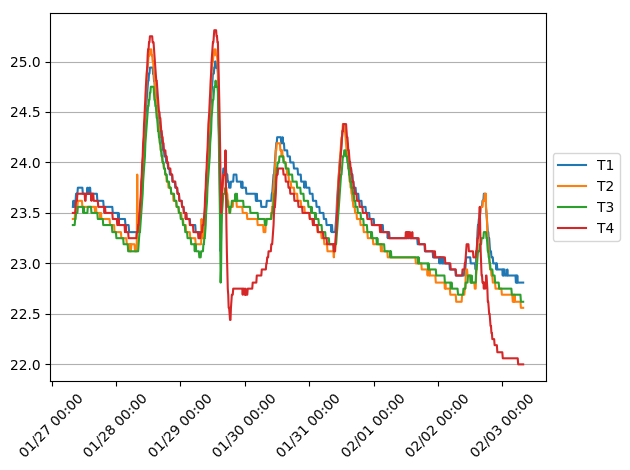

In [15]:
#plot temperatures
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.dates as mdates
mpl.style.use('default')

def time_axis(ax):
    ax.grid(axis='y')
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%m/%d %H:%M'))
    for tick in ax.xaxis.get_major_ticks():
        tick.label.set_fontsize(10) 
        tick.label.set_rotation(45)

folder = '/eos/user/m/meridian/www/plots/IoTLab/ASB_LoraGW_2/'
def save_fig(fig,name):
    fig.tight_layout() #avoid cut figure for vertical axis labels
    for ext in ['.png','.pdf']:
        fig.savefig(folder+name+ext)

fig1, ax1 = plt.subplots()
ax1.plot(df.t1,label='T1')
ax1.plot(df.t2,label='T2')
ax1.plot(df.t3,label='T3')
ax1.plot(df.t4,label='T4')
time_axis(ax1)
ax1.legend(loc='center left', bbox_to_anchor=(1, 0.5))
save_fig(fig1,'temp')

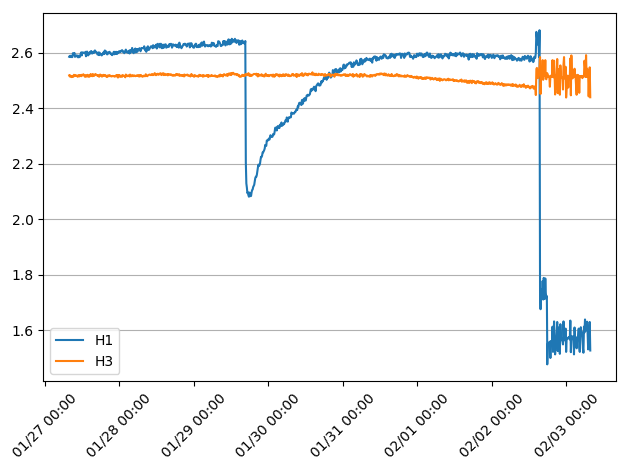

In [16]:
# humidity analysis
fig2, ax2 = plt.subplots()
ax2.plot(df.h1,label='H1')
ax2.plot(df.h3,label='H3')
time_axis(ax2)
ax2.legend()
save_fig(fig2,'hum')

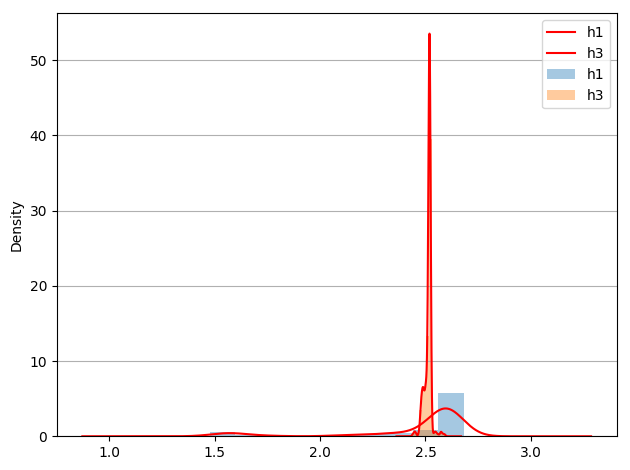

In [17]:
fig3, ax3 = plt.subplots()
for i,key in enumerate(['h1','h3']):
    df[key].plot.hist(ax=ax3,density=True,alpha=.4)    
    df[key].plot.kde(ax=ax3,legend=False,c='red')
ax3.grid(axis='y')
ax3.legend()
save_fig(fig3,'hum_histos')

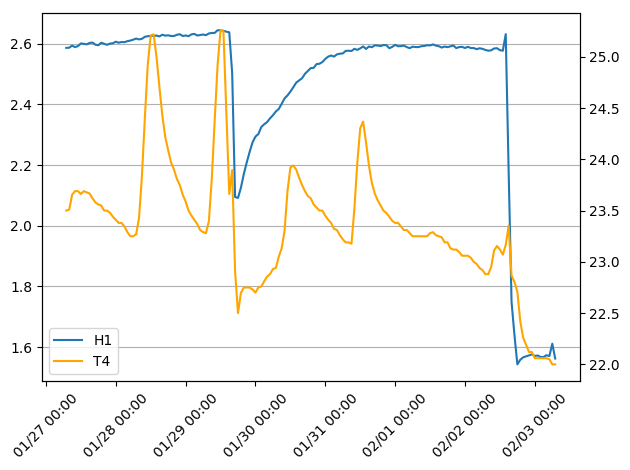

In [18]:
#make average in 1h and check possible correlation T vs H??
hourly=df.resample('60T').mean()

fig4, ax4 = plt.subplots()
ax4_2 = ax4.twinx()
h1=ax4.plot(hourly.h1,label='H1')
t4=ax4_2.plot(hourly.t4,label='T4',c='orange')

#make a single legend
lns = h1+t4
labs = [l.get_label() for l in lns]
ax4.legend(lns, labs, loc=0)

time_axis(ax4)
save_fig(fig4,'hum_vs_temp')

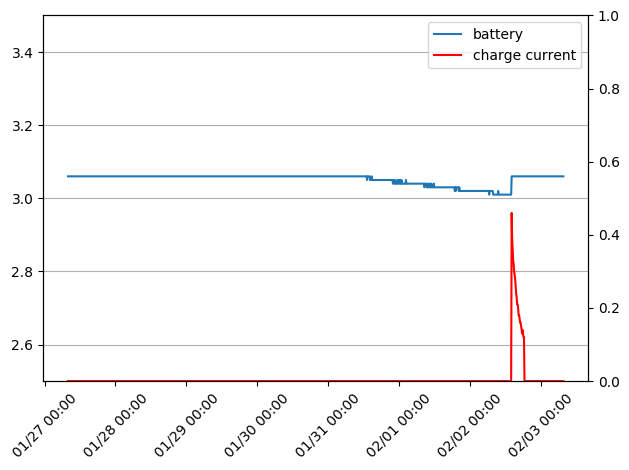

In [19]:
# battery status
fig5, ax5 = plt.subplots()
battery = ax5.plot(df.battery,label='battery')
ax5_2 = ax5.twinx()
charge = ax5_2.plot(df.charge_current,label='charge current',c='r')
time_axis(ax5)
ax5.set_ylim(bottom=2.5,top=3.5)
ax5_2.set_ylim(bottom=0.,top=1.)
lns = battery+charge
labs = [l.get_label() for l in lns]
ax5.legend(lns, labs, loc=0)
save_fig(fig5,'battery')

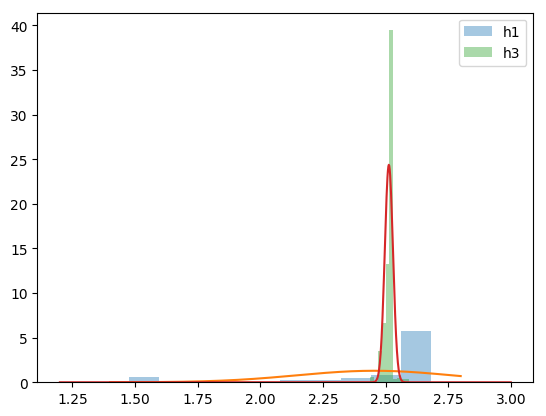

In [20]:
from scipy import stats  
import numpy as np  

for key in ['h1','h3']:
    col=df[key] #get df column as an array
    plt.hist(col, density=True,label=key,alpha=.4)
    
    # find minimum and maximum of xticks, so we know
    # where we should compute theoretical distribution
    xt = plt.xticks()[0]  
    xmin, xmax = min(xt), max(xt)  
    lnspc = np.linspace(xmin, xmax, len(col))

    # normal distribution fit
    m, s = stats.norm.fit(col) # get mean and standard deviation  
    pdf_g = stats.norm.pdf(lnspc, m, s) # now get theoretical values in our interval  
    plt.plot(lnspc, pdf_g) # plot it

plt.legend()